In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [4]:
x_train, y_train,x_test, y_test = load_data()

In [5]:
x_train.shape

(9690, 2304)

In [6]:
y_train.shape

(9690, 1)

In [7]:
x_test.shape

(3090, 2304)

In [8]:
y_train = y_train.values.ravel()

# Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
# random_state: controls randomness of the sample
# n_jobs: number of processors the engine is allowed to use. -1 no limit
# max_depth: depth
# n_estimators: number of trees the forest builds
# oob_score: Out-Of-The-Bag. random forest cross validation 

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)

In [11]:
classifier_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [12]:
classifier_rf.oob_score_

0.7186790505675955

In [13]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(classifier_rf, x_train, y_train, cv=10, scoring='accuracy')

print(f'Cross Validation Scores: {cv}')
print(f'Mean Accuracy: {cv.mean()}')
print(f'Standard Deviation: {cv.std()}')

Cross Validation Scores: [0.46439628 0.48503612 0.57688338 0.68317853 0.66150671 0.65944272
 0.3880289  0.6006192  0.70381837 0.64705882]
Mean Accuracy: 0.5869969040247678
Standard Deviation: 0.10129596958817277


In [14]:
y_predict = classifier_rf.predict(x_train)

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

conf_matrix = confusion_matrix(y_train, y_predict)

accuracy = accuracy_score(y_train, y_predict)
report = classification_report(y_train, y_predict, zero_division=1)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n {report}')



Accuracy: 0.7542827657378741
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       210
           1       0.70      0.85      0.77      2220
           2       0.72      0.81      0.77      2250
           3       0.69      0.80      0.74      1410
           4       0.87      0.83      0.85      1980
           5       1.00      0.37      0.54       210
           6       0.84      0.45      0.59       360
           7       1.00      0.55      0.71       240
           8       0.78      0.61      0.69       540
           9       0.92      0.48      0.63       270

    accuracy                           0.75      9690
   macro avg       0.85      0.58      0.63      9690
weighted avg       0.78      0.75      0.74      9690



# Using Given Test Set

In [16]:
y_predict_test = classifier_rf.predict(x_test)

accuracy_test = accuracy_score(y_test, y_predict_test)
report_test = classification_report(y_test, y_predict_test, zero_division=1)

print(f'Accuracy: {accuracy_test}')
print(f'Classification Report:\n {report_test}')


Accuracy: 0.6226537216828479
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        60
           1       0.62      0.80      0.70       720
           2       0.60      0.70      0.65       750
           3       0.60      0.68      0.63       450
           4       0.72      0.60      0.65       660
           5       1.00      0.00      0.00        60
           6       0.62      0.14      0.23        90
           7       1.00      0.13      0.24        60
           8       0.45      0.47      0.46       150
           9       0.87      0.37      0.52        90

    accuracy                           0.62      3090
   macro avg       0.75      0.39      0.41      3090
weighted avg       0.65      0.62      0.60      3090



# Using Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
y_pred_train = classifier_rf.predict(x_train2)
y_pred_test2 = classifier_rf.predict(x_test2)

# accuracy on the new training set
accuracy_train = accuracy_score(y_train2, y_pred_train)
print(f'Accuracy on the New Training Set: {accuracy_train}')

# accuracy on the new testing set
accuracy_test2 = accuracy_score(y_test2, y_pred_test2)
print(f'Accuracy on the New Testing Set: {accuracy_test2}')


Accuracy on the New Training Set: 0.7541279669762642
Accuracy on the New Testing Set: 0.7549019607843137


# Experimenting with Various Parameters

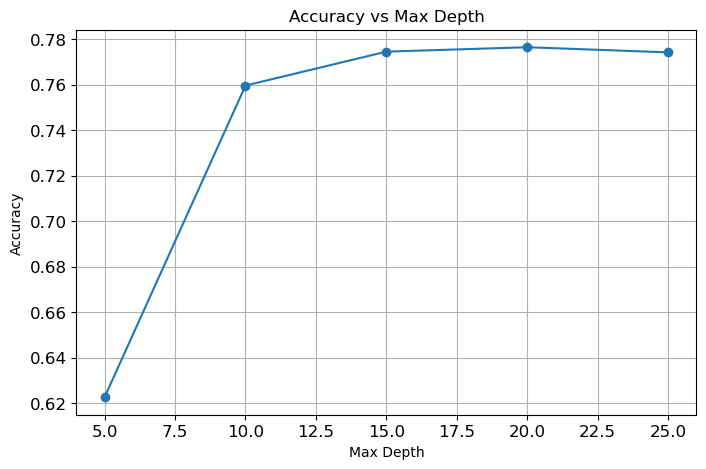

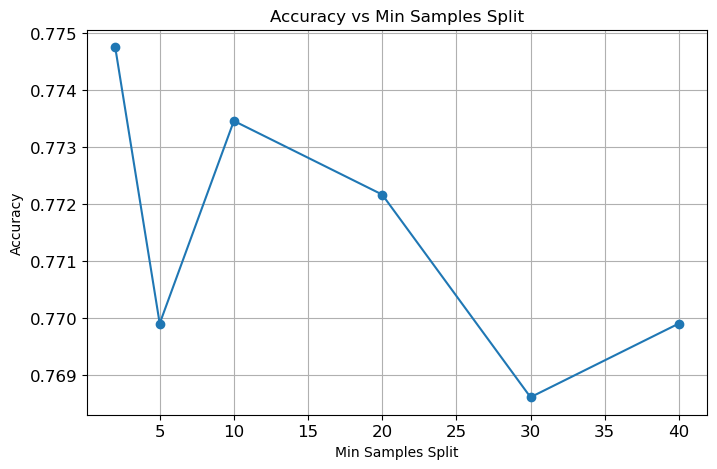

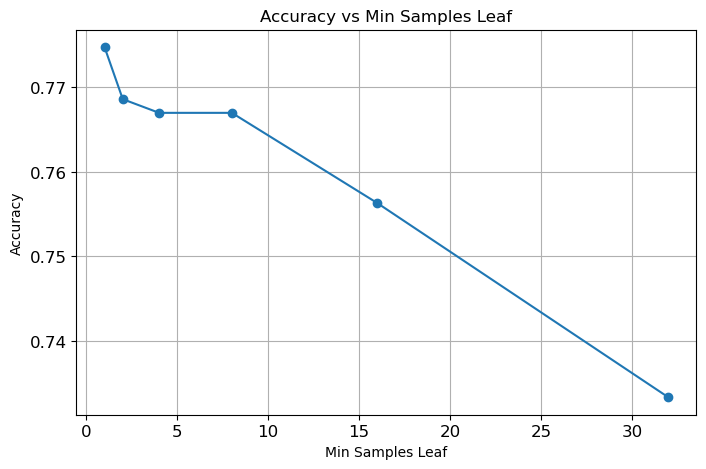

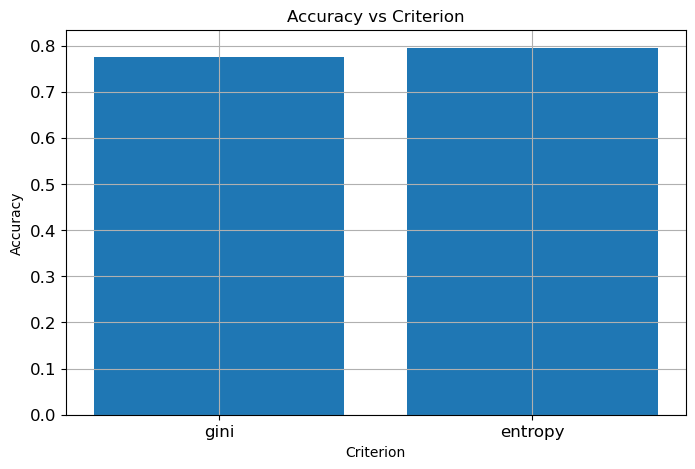

In [18]:

# Experiment with the depth of the tree (max_depth)
depth_values = [None, 5, 10, 15, 20, 25]
accuracy_depth = []

for depth in depth_values:
    rf_model = RandomForestClassifier(max_depth=depth, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_test = rf_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracy_depth.append(accuracy)

# Plot the results for max_depth
plt.figure(figsize=(8, 5))
plt.plot(depth_values, accuracy_depth, marker='o')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Experiment with min_samples_split
split_values = [2, 5, 10, 20, 30, 40]
accuracy_split = []

for split in split_values:
    rf_model = RandomForestClassifier(min_samples_split=split, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_test = rf_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracy_split.append(accuracy)

# Plot the results for min_samples_split
plt.figure(figsize=(8, 5))
plt.plot(split_values, accuracy_split, marker='o')
plt.title('Accuracy vs Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Experiment with min_samples_leaf
leaf_values = [1, 2, 4, 8, 16, 32]
accuracy_leaf = []

for leaf in leaf_values:
    rf_model = RandomForestClassifier(min_samples_leaf=leaf, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_test = rf_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracy_leaf.append(accuracy)

# Plot the results for min_samples_leaf
plt.figure(figsize=(8, 5))
plt.plot(leaf_values, accuracy_leaf, marker='o')
plt.title('Accuracy vs Min Samples Leaf')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

#Experiment with criterion (gini vs entropy)
criterion_values = ['gini', 'entropy']
accuracy_criterion = []

for criterion in criterion_values:
    rf_model = RandomForestClassifier(criterion=criterion, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_test = rf_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracy_criterion.append(accuracy)

# Plot the results for criterion
plt.figure(figsize=(8, 5))
plt.bar(criterion_values, accuracy_criterion)
plt.title('Accuracy vs Criterion')
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


# Varying datasets

In [19]:
def split_dataset(X_train, Y_train, split_ratio):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=split_ratio, random_state=42)

    return x_train, y_train, x_test, y_test

## 30% added to test

In [20]:
x_train_3, y_train_3, x_test_3, y_test_3 = split_dataset(x_train, y_train, 0.3)

y_test = y_test.values.ravel()

new_x_test_30 = np.concatenate([x_test, x_test_3], axis=0)
new_y_test_30 = np.concatenate([y_test, y_test_3], axis=0)

# Verify the shapes of the concatenated sets
print("Shape of Original Test Set:", x_test.shape)
print("Shape of New 30% Test Set:", x_test_3.shape)
print("Shape of Concatenated Test Set:", new_x_test_30.shape)

Shape of Original Test Set: (3090, 2304)
Shape of New 30% Test Set: (2907, 2304)
Shape of Concatenated Test Set: (5997, 2304)


In [21]:
classifier_rf_30= RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf_30.fit(x_train_3, y_train_3)


RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [22]:
y_predict_train30 = classifier_rf_30.predict(x_train_3)

accuracy_30 = accuracy_score(y_train_3, y_predict_train30)
report_30 = classification_report(y_train_3, y_predict_train30, zero_division=1)

print(f'Accuracy: {accuracy_30}')
print(f'Classification Report:\n {report_30}')

Accuracy: 0.754828247088309
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       135
           1       0.71      0.81      0.76      1555
           2       0.73      0.81      0.77      1572
           3       0.70      0.82      0.76       984
           4       0.85      0.82      0.84      1393
           5       1.00      0.17      0.29       139
           6       0.86      0.60      0.70       260
           7       1.00      0.62      0.76       175
           8       0.74      0.64      0.69       382
           9       0.94      0.52      0.67       188

    accuracy                           0.75      6783
   macro avg       0.85      0.58      0.62      6783
weighted avg       0.77      0.75      0.74      6783



In [23]:
y_predict_test30 = classifier_rf.predict(new_x_test_30)

accuracy_test30 = accuracy_score(new_y_test_30, y_predict_test30)
report_test30 = classification_report(new_y_test_30, y_predict_test30, zero_division=1)


print(f'Accuracy: {accuracy_test30}')
print(f'Classification Report:\n {report_test30}')

d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.6866766716691679
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       135
           1       0.66      0.82      0.73      1385
           2       0.66      0.76      0.71      1428
           3       0.64      0.74      0.69       876
           4       0.80      0.71      0.75      1247
           5       1.00      0.21      0.35       131
           6       0.74      0.27      0.40       190
           7       1.00      0.30      0.46       125
           8       0.59      0.56      0.58       308
           9       0.90      0.41      0.57       172

    accuracy                           0.69      5997
   macro avg       0.80      0.48      0.52      5997
weighted avg       0.71      0.69      0.67      5997



## 60% added to test

In [24]:
x_train_6, y_train_6, x_test_6, y_test_6 = split_dataset(x_train, y_train, 0.6)

new_x_test_60 = np.concatenate([x_test, x_test_6], axis=0)
new_y_test_60 = np.concatenate([y_test, y_test_6], axis=0)

# Verify the shapes of the concatenated sets
print("Shape of Original Test Set:", x_test.shape)
print("Shape of New 60% Test Set:", x_test_6.shape)
print("Shape of Concatenated Test Set:", new_x_test_60.shape)

Shape of Original Test Set: (3090, 2304)
Shape of New 60% Test Set: (5814, 2304)
Shape of Concatenated Test Set: (8904, 2304)


In [25]:
classifier_rf_60= RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf_60.fit(x_train_6, y_train_6)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [26]:
y_predict_train60 = classifier_rf_60.predict(x_train_6)

accuracy_60 = accuracy_score(y_train_6, y_predict_train60)
report_60 = classification_report(y_train_6, y_predict_train60, zero_division=1)

print(f'Accuracy: {accuracy_60}')
print(f'Classification Report:\n {report_60}')

Accuracy: 0.7739938080495357
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        76
           1       0.71      0.85      0.77       884
           2       0.74      0.83      0.78       892
           3       0.73      0.82      0.77       544
           4       0.88      0.85      0.86       829
           5       1.00      0.17      0.29        81
           6       0.96      0.61      0.74       141
           7       1.00      0.50      0.67        96
           8       0.81      0.69      0.75       222
           9       0.93      0.56      0.70       111

    accuracy                           0.77      3876
   macro avg       0.88      0.59      0.63      3876
weighted avg       0.80      0.77      0.76      3876



In [27]:
y_predict_test60 = classifier_rf.predict(new_x_test_60)

accuracy_test60 = accuracy_score(new_y_test_60, y_predict_test60)
report_test60 = classification_report(new_y_test_60, y_predict_test60, zero_division=1)

print(f'Accuracy: {accuracy_test60}')
print(f'Classification Report:\n {report_test60}')

d:\Projects\anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.7070979335130279
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       194
           1       0.67      0.83      0.74      2056
           2       0.68      0.77      0.72      2108
           3       0.66      0.75      0.70      1316
           4       0.82      0.75      0.78      1811
           5       1.00      0.27      0.42       189
           6       0.80      0.35      0.49       309
           7       1.00      0.44      0.61       204
           8       0.65      0.58      0.61       468
           9       0.90      0.43      0.58       249

    accuracy                           0.71      8904
   macro avg       0.82      0.52      0.57      8904
weighted avg       0.73      0.71      0.69      8904



# Grid Search

In [28]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 5, 8, 16, 32, 50],
    'n_estimators': [10, 25, 30, 50],
    'criterion': ['gini', 'entropy'],
}

from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 10,
                           n_jobs=-1,
                           scoring="accuracy")


grid_search.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 4, 5, 8, 16, 32, 50],
                         'n_estimators': [10, 25, 30, 50]},
             scoring='accuracy')

In [29]:
grid_search.best_score_


0.8008255933952528

In [30]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                       n_estimators=50, n_jobs=-1, random_state=42)